[View in Colaboratory](https://colab.research.google.com/github/erconui/cs501r/blob/master/first_dll.ipynb)

In [1]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

    100% |████████████████████████████████| 519.5MB 35kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5912c000 @  0x7f205f5421c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.8MB/s 
    100% |████████████████████████████████| 2.0MB 7.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import pdb
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm

assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type

In [0]:
class Conv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, init, stride=1, 
               padding=0, dilation=1, groups=1, bias=True):
    self.__dict__.update(locals())
    super(Conv2d, self).__init__()
    
    self.weight = Parameter(torch.Tensor(out_channels, in_channels,
                                         *kernel_size))
    
    self.bias = Parameter(torch.Tensor(out_channels))
    
    if init=="Uniform":
        ## Uniform Initialization
        self.weight.data.uniform_(-1,1)
        self.bias.data.uniform_(0,0)
    if init=="XE":
        ## XE Initialization
        self.weight.data.fill_(0.01)
        self.bias.data.fill_(0.01)
    if init=="Orthogonal":
        ## Orthogonal Initialization
        self.init_orthogonal(in_channels, out_channels, kernel_size)

  def init_orthogonal(self, in_channels, out_channels, kernel_size):
    width = in_channels*kernel_size[0]*kernel_size[1]
    X = np.random.random((out_channels, width))
    U, _, VT = np.linalg.svd(X,full_matrices=False)
    if out_channels > width:
      weight = U
    else:
      weight = VT
    weight = weight.reshape((
        out_channels, in_channels, kernel_size[0], kernel_size[1]))
    self.weight = Parameter(torch.tensor(weight).float())
    
  def forward(self, x):
    return F.conv2d(x, self.weight, self.bias, self.stride, self.padding,
                    self.dilation, self.groups)
  
  def extra_repr(self):
    return '501r is so cool'

class CrossEntropyLoss(nn.Module):
  def __init__(self, weight=None, size_average=None, ignore_index=-100,
               reduce=None, reduction='elementwise_mean'):
    super(CrossEntropyLoss, self).__init__()
    
  def forward(self, x, labels):
    alpha = torch.max(x).item()
    softmax = -torch.log(
        torch.exp(x-alpha)/torch.exp(x-alpha).sum(1, keepdim=True))
    r = torch.arange(softmax.size(0))
    return softmax[r, labels].mean()
  
class ConvNetwork(nn.Module):
  def __init__(self, dataset, conv2d_init=None, million_parameters=False):
    super(ConvNetwork, self).__init__()
    x, y = dataset[0]
    c,h,w = x.size()
    output = 10
    
    if million_parameters:
        self.net = nn.Sequential(
              nn.Conv2d(c, 125, (3,3), padding=(1,1)),
              nn.ReLU(),
              nn.Conv2d(125, 125, (3,3), padding=(1,1)),
              nn.ReLU(),
              nn.Conv2d(125, 125, (3,3), padding=(1,1)),
              nn.ReLU(),
              nn.Conv2d(125, output, (28,28), padding=(0,0))
        )
    else:
        self.net = nn.Sequential(
              Conv2d(c, 10, (3,3), padding=(1,1), init=conv2d_init),
              nn.ReLU(),
              Conv2d(10, output, (28,28), padding=(0,0), init=conv2d_init)
        )
   
  def forward(self, x):
    return self.net(x).squeeze(2).squeeze(2)

class FashionMNISTProcessedDataset(Dataset):
  def __init__(self, root, train=True):
    self.data = datasets.FashionMNIST(
        root, train=train, transform=transforms.ToTensor(), download=True)
    
  def __getitem__(self, i):
    x, y = self.data[i]
    return x, y
  
  def __len__(self):
    return len(self.data)

def count_parameters(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            total_param += np.prod(param.size())
    return total_param

In [0]:
def train_data(model, objective, optimizer, train_loader, val_loader):
    losses = []
    validations = []
    accuracies = []
    val_accuracies = []
    for epoch in range(1):
      loop = tqdm(total=len(train_loader), position=0)
      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)

        optimizer.zero_grad()
        y_hat = model(x)

        loss = objective(y_hat,y_truth)

        loss.backward()

        losses.append(loss)
        accuracy = (torch.softmax(y_hat, 1).argmax(1) == y_truth).float().mean()
        accuracies.append(accuracy)
        loop.set_description('loss:{:.4f}'.format(loss.item()))
        loop.update(1)

        optimizer.step()

        if batch % 50 == 0:
          vals = []
          tmp_accuracies = []
          for x1,y in val_loader:
            x1, y_truth1 = x1.cuda(async=True), y.cuda(async=True)
            y_hat = model(x1)
            tmp = objective(y_hat, y_truth1).item()
            vals.append(tmp)
            accuracy = (y_hat.argmax(1) == y_truth1).float().mean()
            tmp_accuracies.append(accuracy)

          val_accuracies.append((len(losses), np.mean(tmp_accuracies)))
          validations.append((len(losses), np.mean(vals)))

      loop.close()
    return validations, losses, val_accuracies, accuracies

In [0]:
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=True)
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

loss:0.1750: 100%|██████████| 1429/1429 [03:54<00:00,  6.10it/s]


Number of Parameters is:  1262760


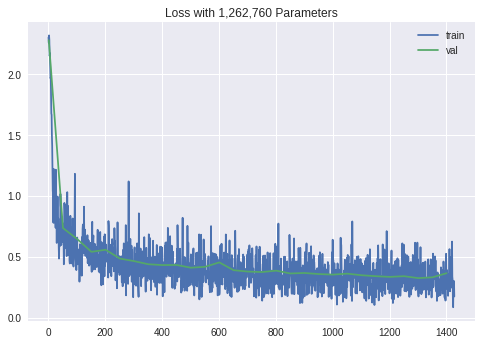

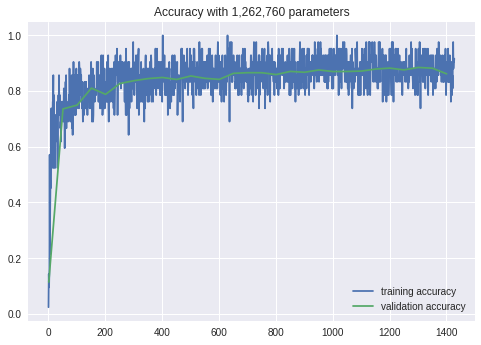

In [19]:
model = ConvNetwork(train_dataset, million_parameters=True)

model.cuda()
objective = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

validations, losses, val_accuracies, accuracies = train_data(model, objective,
                                                             optimizer,
                                                             train_loader,
                                                             val_loader)
print("Number of Parameters is: ", count_parameters(model))
a, b = zip(*validations)
# fig, ax = plt.subplots(1,2)
plt.title("Loss with 1,262,760 Parameters")
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
plt.title("Accuracy with 1,262,760 parameters")
plt.plot(accuracies, label='training accuracy')
a, b = zip(*val_accuracies)
plt.plot(a, b, label="validation accuracy")
plt.legend()
plt.show()

loss:0.6499: 100%|██████████| 1429/1429 [01:28<00:00, 16.08it/s]


Number of Parameters is:  78510


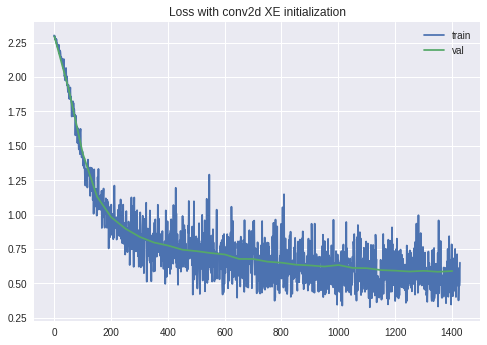

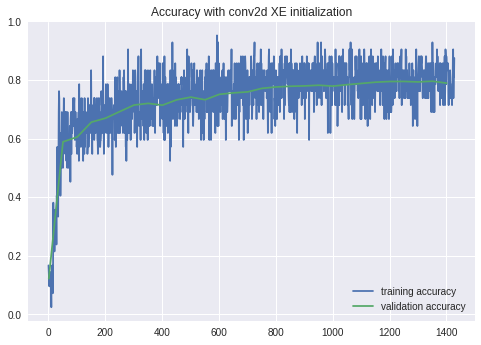

In [20]:
model = ConvNetwork(train_dataset, conv2d_init='XE')

model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

validations, losses, val_accuracies, accuracies = train_data(model, objective,
                                                             optimizer,
                                                             train_loader,
                                                             val_loader)
print("Number of Parameters is: ", count_parameters(model))
a, b = zip(*validations)
# fig, ax = plt.subplots(1,2)
plt.title("Loss with conv2d XE initialization")
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
plt.title("Accuracy with conv2d XE initialization")
plt.plot(accuracies, label='training accuracy')
a, b = zip(*val_accuracies)
plt.plot(a, b, label="validation accuracy")
plt.legend()
plt.show()

loss:2.8218: 100%|██████████| 1429/1429 [01:29<00:00, 16.03it/s]


Number of Parameters is:  78510


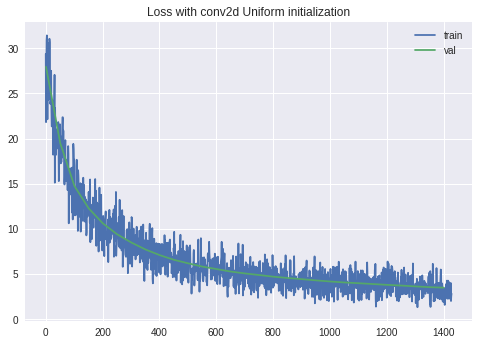

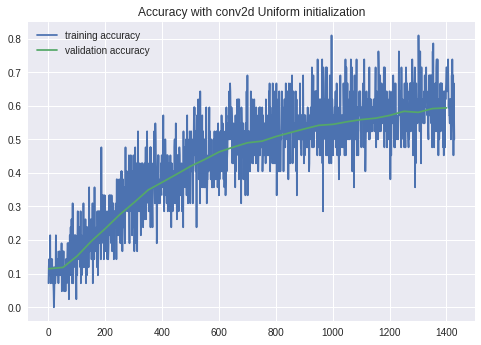

In [21]:
model = ConvNetwork(train_dataset, conv2d_init='Uniform')

model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

validations, losses, val_accuracies, accuracies = train_data(model, objective,
                                                             optimizer,
                                                             train_loader,
                                                             val_loader)
print("Number of Parameters is: ", count_parameters(model))
a, b = zip(*validations)
# fig, ax = plt.subplots(1,2)
plt.title("Loss with conv2d Uniform initialization")
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
plt.title("Accuracy with conv2d Uniform initialization")
plt.plot(accuracies, label='training accuracy')
a, b = zip(*val_accuracies)
plt.plot(a, b, label="validation accuracy")
plt.legend()
plt.show()

loss:0.4739: 100%|██████████| 1429/1429 [01:29<00:00, 15.90it/s]


Number of Parameters is:  78510


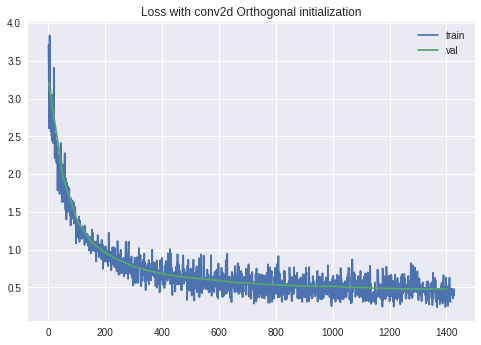

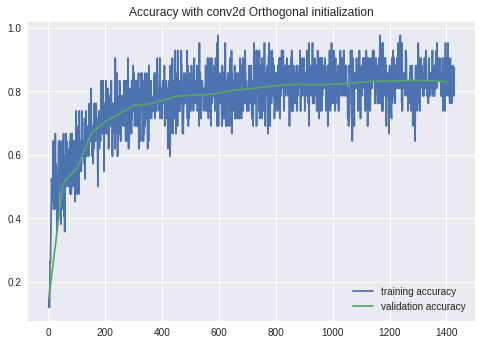

In [22]:
model = ConvNetwork(train_dataset, conv2d_init='Orthogonal')

model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loader = DataLoader(train_dataset, batch_size=42, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=42, pin_memory=True)

validations, losses, val_accuracies, accuracies = train_data(model, objective,
                                                             optimizer,
                                                             train_loader,
                                                             val_loader)
print("Number of Parameters is: ", count_parameters(model))
a, b = zip(*validations)
# fig, ax = plt.subplots(1,2)
plt.title("Loss with conv2d Orthogonal initialization")
plt.plot(losses, label='train')
plt.plot(a, b, label='val')
plt.legend()
plt.show()
plt.title("Accuracy with conv2d Orthogonal initialization")
plt.plot(accuracies, label='training accuracy')
a, b = zip(*val_accuracies)
plt.plot(a, b, label="validation accuracy")
plt.legend()
plt.show()

# Part 4
## Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3,3), padding=(1,1))

(c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3,3), padding=(2,2))

(c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3,3), padding=(6,6))

## Using a Kernel size of 5×5:

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5,5), padding=(2,2))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5,5), padding=(3,3))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5,5), padding=(9,9))

## Using Kernel size of 5×3:

 (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5,3), padding=(1,0))

(c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5,3), padding=(2,1))

(c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5,3), padding=(3,2))

(c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5,3), padding=(9,8))

## Determine the kernel that requires the smallest padding size to make the following mappings possible:

 (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels=10, kernel_size=(4,4), padding=(1,0))

(c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(1,1), padding=(0,0))